<a href="https://colab.research.google.com/github/justdelly/My-IE423-Tasks/blob/main/notebooks/n3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

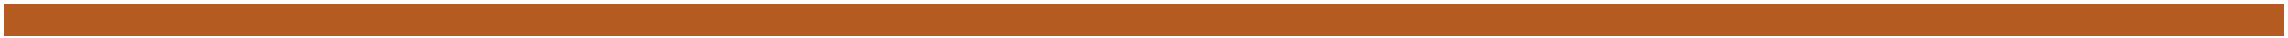

## <font color='#475468'> Black Friday Sales: Predicting Customer Purchase Amount</font>


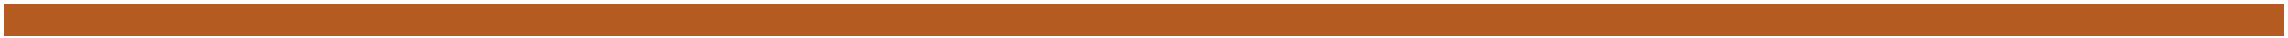

## Initialize

In [57]:
import pandas as pd
import numpy as np

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Load Data

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
dfMlb = pd.read_csv('/content/drive/MyDrive/Datasets/black_friday_sales_data.csv')

dfMlb.head()


,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [43]:
dfMlb.columns


Index(['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3', 'Purchase'],
      dtype='object')

In [44]:
# Select target as a series and features as dataframe
y = dfMlb.loc[:,['Purchase']].values.ravel()
X = dfMlb.drop(['Purchase'],axis=1)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8, test_size=0.2,random_state=1)

In [45]:
X.head()


,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN


## Build Random Forest Model

In [46]:
from sklearn.ensemble import RandomForestRegressor

# Function for building and scoring Random Forest models
def get_random_forest_mae(X_trn, X_tst, y_trn, y_tst):
    mdlRfsMlb = RandomForestRegressor(random_state=1)
    mdlRfsMlb.fit(X_trn, y_trn)
    y_tst_prd = mdlRfsMlb.predict(X_tst)
    mae = mean_absolute_error(y_tst, y_tst_prd)
    return (mae)

Let's try to build a model with all the features...

In [47]:
# Try to build a model using all features
get_random_forest_mae(X_train, X_test, y_train, y_test)

ValueError: could not convert string to float: 'P00304042'

Seems like some of the columns are non-numeric.  So, how many different types of data exists?

## Numerical Features
Columns with quantitative data - either Discrete or Continuous are called Numerical Features.

In [48]:
# Select numeric features
cols_num = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]
Xnum = X[cols_num]

# Split numeric features into training and test sets
Xnum_train, Xnum_test, y_train, y_test = train_test_split(Xnum,y,train_size=0.8, test_size=0.2,random_state=1)

cols_num

['User_ID',
 'Occupation',
 'Marital_Status',
 'Product_Category_1',
 'Product_Category_2',
 'Product_Category_3']

In [49]:
# Try to build a model using all numeric features
get_random_forest_mae(Xnum_train, Xnum_test, y_train, y_test)

ValueError: Input X contains NaN.
RandomForestRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

Seems like some of the numeric columns have **Missing Values**.

In [14]:
# Count number of missing values in each column of the training data
Xnum_train.isna().sum()

User_ID                    0
Occupation                 0
Marital_Status             0
Product_Category_1         0
Product_Category_2    138892
Product_Category_3    306504
dtype: int64

As expected, there are some missing values.  Let's see how to deal with it...

#### Approach 1. Fill missing values by Imputation
**Imputation** fills in the missing values with some number. For instance, we can fill in the mean value along each column.

The imputed value won't be exactly right in most cases, but it usually leads to more accurate models than you would get from dropping the column entirely.

In [20]:
# Replace with specific value (0, bfill, ffill)
Xnum_train_repnull = Xnum_train.fillna(method = 'ffill')
Xnum_test_repnull = Xnum_test.fillna(method = 'ffill')

# Fill any remaining NaNs (e.g., at the beginning of columns) with 0
Xnum_train_repnull = Xnum_train_repnull.fillna(0)  # Fill remaining NaNs with 0
Xnum_test_repnull = Xnum_test_repnull.fillna(0)    # Fill remaining NaNs with 0

# Verify if NaNs still exist
print("Remaining NaNs in Xnum_train_repnull:", Xnum_train_repnull.isna().sum().sum())
print("Remaining NaNs in Xnum_test_repnull:", Xnum_test_repnull.isna().sum().sum())

print('MAE from Approach 2 (Replace missing values with forward fill):')
print(get_random_forest_mae(Xnum_train_repnull, Xnum_test_repnull, y_train, y_test))

Remaining NaNs in Xnum_train_repnull: 0
Remaining NaNs in Xnum_test_repnull: 0
MAE from Approach 2 (Replace missing values with forward fill):
2272.0611026771116


In [21]:
# Replace with mean value
Xnum_train_repnull = Xnum_train.fillna(Xnum_train.mean())
Xnum_test_repnull = Xnum_test.fillna(Xnum_test.mean())

print('MAE from Approach 2 (Replace missing values with mean):')
print(get_random_forest_mae(Xnum_train_repnull, Xnum_test_repnull, y_train, y_test))

MAE from Approach 2 (Replace missing values with mean):
2193.456214200903


Replacing with mean value gave better result than forwardfill and fixed value combined.

#### Approach 2. Drop columns with missing values
The simplest option is to **drop columns** with missing values.

In [58]:
# Identify columns with missing values and then drop such columns
cols_num_null = [col for col in Xnum_train.columns
    if Xnum_train[col].isnull().any()]
Xnum_train_drpnull = Xnum_train.drop(cols_num_null, axis=1)
Xnum_test_drpnull = Xnum_test.drop(cols_num_null, axis=1)

In [38]:
print('MAE from Approach 1 (Drop features with missing values):')
print(get_random_forest_mae(Xnum_train_drpnull, Xnum_test_drpnull, y_train, y_test))

MAE from Approach 1 (Drop features with missing values):
2091.2402741391948


 Dataset has 2 columns that have almost total 450.000 missing points so it is a good idea to drop those columns. Consequently we see a less mae.

So we drop the columns and continue.

In [52]:
X_train = X_train.drop(['Product_Category_2', 'Product_Category_3'], axis=1)
X_test = X_test.drop(['Product_Category_2', 'Product_Category_3'], axis=1)

Next, let's try to improve the model by including some non-numeric features...

utexas_ds_orie_divider_gray.png

## Non-numerical Features

We have already seen the error generated by non-numeric features, but let's try to convert them to numeric values so that they can be used in the model.

In [56]:
# Select non-numeric features
cols_obj = [col for col in X.columns if X[col].dtype == 'object']
cols_obj

['Product_ID', 'Gender', 'Age', 'City_Category', 'Stay_In_Current_City_Years']

In [53]:
# Label encoding on all non-numeric features

from sklearn.preprocessing import LabelEncoder

Xle_train = X_train.copy()
Xle_test = X_test.copy()
# Apply label encoder to each column with non-numeric data
label_encoder = LabelEncoder()
for col in cols_obj:
    Xle_train[col] = label_encoder.fit_transform(X_train[col])
    Xle_test[col] = label_encoder.transform(X_test[col])

ValueError: y contains previously unseen labels: 'P00206242'

We see that Product Id is not a numerical feature nor a categorical feature since it is unique for every product.

There are too many values to be label encoded.  So, we would need to take only those non-numeric features with low cardinality aka **Categorical features**.

In [60]:
# Select categorical features
cols_cat = [col for col in X.columns if X[col].dtype == 'object' and X[col].nunique()<10]
cols_num = ['User_ID','Occupation','Marital_Status','Product_Category_1']
cols_cat


['Gender', 'Age', 'City_Category', 'Stay_In_Current_City_Years']

In [61]:
# Label encoding on only categorical features

from sklearn.preprocessing import LabelEncoder

Xle_train = X_train.copy()
Xle_test = X_test.copy()
# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for col in cols_cat:
    Xle_train[col] = label_encoder.fit_transform(X_train[col])
    Xle_test[col] = label_encoder.transform(X_test[col])

In [62]:
# Encode and Build/Score using all Categorical columns

mae = get_random_forest_mae(Xle_train[cols_num + cols_cat], Xle_test[cols_num + cols_cat], y_train, y_test)
print("MAE from Label Encoding all Categorical columns:")
print(mae)

MAE from Label Encoding all Categorical columns:
2086.9820597803287


So, by including the Categorical features, the MAE is further reduced to to 2086.98 which is slightly less than last.

## Build Gradient Boosted Tree Model

Let's begin by training a simple Gradient Boosting model...

In [63]:
from xgboost import XGBRegressor

#Build and score default Gradient Boosting Model
mdlXgbMlb = XGBRegressor()
mdlXgbMlb.fit(Xle_train[cols_num + cols_cat], y_train)
y_test_pred = mdlXgbMlb.predict(Xle_test[cols_num + cols_cat])
mae = mean_absolute_error(y_test_pred, y_test)

print("MAE from default XGBoost model:")
print(mae)

MAE from default XGBoost model:
2138.092662320839


Hold on. The result here is worse than what obtained from our previous Random Forest model.  Let's try to improve this by **tuning the parameters** that drive the Gradient Boosting model.  Below are some popular parameters...

`n_estimators`: maximum number of decision trees that will be ensembled

`max_depth`: maximum depth of each tree (typically 3-10)

`learning_rate`: weight applied to each tree (typically 0.01-0.2)

In [81]:
#Build and score a tuned Gradient Boosting Model
mdlXgbMlb = XGBRegressor(n_estimators=2150, learning_rate=0.17, max_depth=6)
mdlXgbMlb.fit(Xle_train[cols_num + cols_cat], y_train)
y_test_pred = mdlXgbMlb.predict(Xle_test[cols_num + cols_cat])
mae = mean_absolute_error(y_test_pred, y_test)

print("MAE from tuned XGBoost model:")
print(mae)

MAE from tuned XGBoost model:
2076.1628779819976


In [82]:
dfMlb['Purchase'].mean()

9263.968712959126

The Error rate is %22.41. Current model can predict the purchase with %78 accuracy.

utexas_ds_orie_divider_gray.png